In [1]:
import torch
from torch import nn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

training_set = torchvision.datasets.CIFAR10('./data', train=True, 
                                            download=True,transform=transform)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)

validation_set = torchvision.datasets.CIFAR10('./data', train=False,
                                            download=True,transform=transform)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)


print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


In [3]:
def unsupervised_labels(image_batch):
    flatten_labels = []
    for image in image_batch:
        squeeze_image = image.squeeze()
        label = np.reshape(squeeze_image, -1)
        flatten_labels.append(label)
    return torch.stack(flatten_labels)

training_labels = [unsupervised_labels(batch[0]).to(device) for batch in training_loader]
validation_labels = [unsupervised_labels(batch[0]).to(device) for batch in validation_loader]

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size=1024, hidden_layer_size=32):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.input_size = input_size
        self.output_size = input_size
        self.encoder = nn.Linear(self.input_size, self.hidden_layer_size)
        self.decoder = nn.Linear(hidden_layer_size, self.output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # forward for encoder
        x = self.encoder(x)
        # forward for decoder
        x = self.decoder(x)
        return x

model = AutoEncoder().to(device)

In [9]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch = 50

In [14]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    for i, (tdata, _) in enumerate(training_loader):
        inputs = tdata.view(tdata.shape[0], -1).to(device)

        labels = training_labels[i]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100
            print("batch {} loss:{}".format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    return last_loss

In [20]:
def compute_nmse(outputs, labels):
    mse = ((outputs - labels) ** 2).mean(axis=1)
    norm = (labels ** 2).mean(axis=1)
    nmse = mse / norm
    return nmse

def compute_mae(outputs, labels):
    mae = torch.abs(outputs - labels).mean(axis=1)
    return mae

In [31]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 50

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH{}'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    running_vloss = 0.0
    
    total_nmse = torch.Tensor().to(device)  # Use PyTorch tensor for efficiency
    total_mae = torch.Tensor().to(device)
    total_samples = 0
    model.eval()
    with torch.no_grad():
        for i, (vdata, _) in enumerate(validation_loader):
            vinputs = vdata.view(vdata.shape[0], -1).to(device)
            vlabels = validation_labels[i]
            voutputs = model(vinputs)
            nmse = compute_nmse(voutputs, vlabels)
            mae = compute_mae(voutputs, vlabels)
            total_nmse = torch.cat((total_nmse, nmse.unsqueeze(0)), dim=1)  # Efficiently concatenate tensors
            total_mae = torch.cat((total_mae, mae.unsqueeze(0)), dim=1)
            total_samples += vdata.size(0)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    total_nmse = total_nmse.flatten().cpu().numpy()
    total_mae = total_mae.flatten().cpu().numpy()
    print('nmse: {}'.format(total_nmse))
    print('mae: {}'.format(mae))
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss, 'Validation' : avg_vloss},
                      epoch_number + 1)

    writer.flush()
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH1
batch 100 loss:0.05631983008235693
batch 200 loss:0.057157944776117804
batch 300 loss:0.056434975638985634
batch 400 loss:0.05648297540843487
batch 500 loss:0.056494259461760524
batch 600 loss:0.0559496109560132
batch 700 loss:0.056919806599617005
LOSS train 0.056919806599617005 valid 0.05638476833701134
nmse: [0.13455139 0.4680297  0.23216903 ... 0.12032188 0.15642512 0.11324117]
mae: tensor([0.1430, 0.1353, 0.1675, 0.1343, 0.2557, 0.2123, 0.3844, 0.2208, 0.2162,
        0.2058, 0.2856, 0.1774, 0.2253, 0.2105, 0.1428, 0.1264],
       device='cuda:0')
EPOCH2
batch 100 loss:0.05637755442410707
batch 200 loss:0.057246743552386764
batch 300 loss:0.05649072241038084
batch 400 loss:0.05650378327816725
batch 500 loss:0.05643672339618206
batch 600 loss:0.05593788389116525
batch 700 loss:0.05695688217878342
LOSS train 0.05695688217878342 valid 0.05645148828625679
nmse: [0.1386361  0.46713245 0.22896944 ... 0.12711667 0.14989707 0.11343268]
mae: tensor([0.1389, 0.1350, 0.1670, 0.1333, 0.

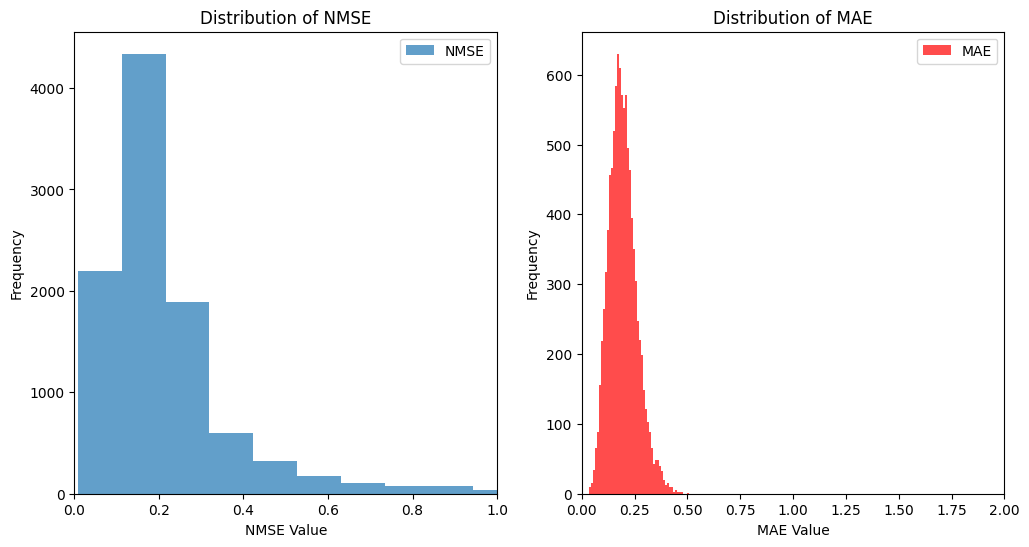

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 设置图形的大小
plt.figure(figsize=(12, 6))

# 绘制 NMSE 的分布
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.hist(total_nmse, bins=200, alpha=0.7, label='NMSE')
# plt.yscale('log')  # 如果需要，开启对数尺度
plt.xlabel('NMSE Value')
plt.ylabel('Frequency')
plt.title('Distribution of NMSE')
plt.xlim(0, 1)  # 根据实际数据范围设置
plt.legend()

# 绘制 MAE 的分布
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.hist(total_mae, bins=50, alpha=0.7, color='red', label='MAE')
plt.xlabel('MAE Value')
plt.ylabel('Frequency')
plt.title('Distribution of MAE')
plt.xlim(0, 2)  # 根据实际数据范围设置
plt.legend()

# 显示整个图表
plt.show()